# Anwendung FLAIR-INC Model

In [ ]:
pip install rasterio

## Vorbereitung Modell

@inproceedings{ign-flair,
      title={FLAIR: a Country-Scale Land Cover Semantic Segmentation Dataset From Multi-Source Optical Imagery},
      author={Anatol Garioud and Nicolas Gonthier and Loic Landrieu and Apolline De Wit and Marion Valette and Marc Poupée and Sébastien Giordano and Boris Wattrelos},
      year={2023},
      booktitle={Advances in Neural Information Processing Systems (NeurIPS) 2023},
      doi={https://doi.org/10.48550/arXiv.2310.13336},

}


es wird nun diese MOdell hier verwendet:
https://huggingface.co/IGNF/FLAIR-INC_rgbi_15cl_resnet34-unet

Die Anleitung dazu gibt es in gitHub:
https://github.com/IGNF/FLAIR-1

In [ ]:
#Klone das FLAIR-1 Repository und installiere die erforderlichen Abhängigkeiten.

!git clone https://github.com/IGNF/FLAIR-1.git
%cd FLAIR-1
!pip install -e .

fatal: destination path 'FLAIR-1' already exists and is not an empty directory.
/content/FLAIR-1
Obtaining file:///content/FLAIR-1
  Preparing metadata (setup.py) ... done
  Attempting uninstall: flair
    Found existing installation: flair 0.2.0
    Uninstalling flair-0.2.0:
      Successfully uninstalled flair-0.2.0
  Running setup.py develop for flair


## Test mit einem Bild - CPU

In [ ]:
yaml_content = """
output_path: /content/drive/MyDrive/LabelingModel/output
output_name: result_raster

input_img_path: /content/drive/MyDrive/Rasterdateien_GemeindeZürich/Parzelle_AF2399_2207.tif
channels: [1, 2, 3, 4]  # RGB + Nahes Infrarot (NIR)

img_pixels_detection: 512
margin: 128
output_type: "argmax"
n_classes: 19

model_weights: /content/drive/MyDrive/LabelingModel/FLAIR-INC_rgbi_15cl_resnet34-unet_weights.pth
model_framework:
    model_provider: SegmentationModelsPytorch
    HuggingFace:
        org_model:
    SegmentationModelsPytorch:
        encoder_decoder: resnet34_unet

batch_size: 4
use_gpu: true
model_name: 'unet'
encoder_name: 'resnet34'
num_worker: 2

write_dataframe: false

norma_task:
  - norm_type: custom
    norm_means: [105.08, 110.87, 101.82, 106.38]
    norm_stds: [52.17, 45.38, 44.0, 39.69]
"""

# Speichere das YAML-File
with open("/content/drive/MyDrive/LabelingModel/flair-1-config-detect.yaml", "w") as file:
    file.write(yaml_content)


Ausführen des Modells

In [ ]:
!flair-detect --conf=/content/drive/MyDrive/LabelingModel/flair-1-config-detect.yaml



    ##############################################
    ZONE DETECTION
    ##############################################

    CUDA available? True

    |- output path: /content/drive/MyDrive/LabelingModel/output
    |- output raster name: result_raster.tif

    |- input image path: /content/drive/MyDrive/Rasterdateien_GemeindeZürich/Parzelle_AF2399_2207.tif
    |- channels: [1, 2, 3, 4]
    |- resolution: (0.05, 0.05)

    |- image size for detection: 512
    |- overlap margin: 128
    |- write dataframe: False
    |- number of classes: 19
    |- normalization: custom
    |- output type: argmax

    |- model weights path: /content/drive/MyDrive/LabelingModel/FLAIR-INC_rgbi_15cl_resnet34-unet_weights.pth
    |- model arch: unet
    |- encoder: resnet34
    |- model template: SegmentationModelsPytorch
    |- device: cuda
    |- batch size: 4


    [x] sliced input raster to 288 squares...
    [x] loaded model and weights...
    [ ] starting inference...

100% 72/72 [00:19<00:00,  3.74i

### Visualisierung aller 19 Klassen

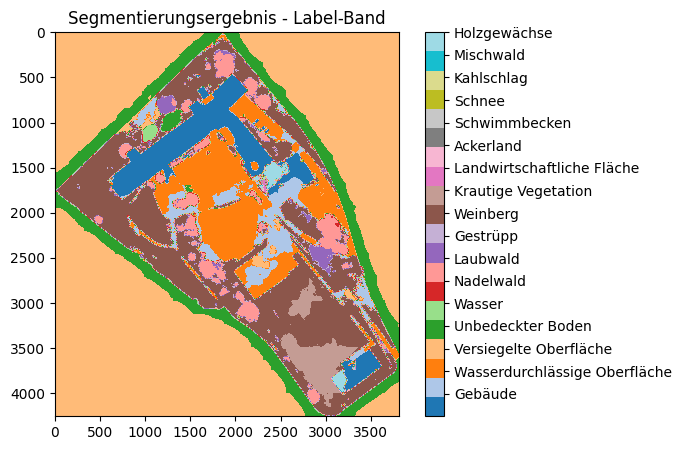

In [ ]:
import rasterio
import matplotlib.pyplot as plt
import numpy as np

# Pfad zu deinem TIFF-Bild
tiff_path = '/content/drive/MyDrive/LabelingModel/output/result_raster.tif'

# Klassenbeschriftungen auf Deutsch
label_names_de = {
    1: 'Gebäude',
    2: 'Wasserdurchlässige Oberfläche',
    3: 'Versiegelte Oberfläche',
    4: 'Unbedeckter Boden',
    5: 'Wasser',
    6: 'Nadelwald',
    7: 'Laubwald',
    8: 'Gestrüpp',
    9: 'Weinberg',
    10: 'Krautige Vegetation',
    11: 'Landwirtschaftliche Fläche',
    12: 'Ackerland',
    13: 'Schwimmbecken',
    14: 'Schnee',
    15: 'Kahlschlag',
    16: 'Mischwald',
    17: 'Holzgewächse',
    18: 'Gewächshaus',
    19: 'Sonstiges'
}

# Bild öffnen und anzeigen
with rasterio.open(tiff_path) as src:
    # Lese alle Bänder
    data = src.read()
    # Zeige das erste Band des Bildes (Label-Band)
    fig, ax = plt.subplots()
    img = ax.imshow(data[0], cmap='tab20')

    # Eine Farblegende mit deutschen Klassenlabels hinzufügen
    cbar = plt.colorbar(img, ax=ax, ticks=range(1, 20))
    cbar.ax.set_yticklabels([label_names_de[i] for i in range(1, 20)])

    plt.title("Segmentierungsergebnis - Label-Band")
    plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)  # Ränder anpassen
    plt.show()


das hat ja jetzt schon super geklappt. Jetzt müssen nur noch die Labels richtig zugeordnet werden.

ausserdem ist mir aufgefallen, dass 19 angezeigt werden obwohl beim model ansich nur 15 Klassen stehen.

Grund dafür ist:
Vorhersageklassen für Landbedeckung : Die ursprüngliche Klassennomenklatur des FLAIR-Datensatzes umfasst 19 Klassen (Einzelheiten finden Sie auf der FLAIR- Datensatzseite). Allerdings wurden während des Trainings 3 Klassen mit unsicherer Kennzeichnung (Gemischt (16), Holzig (17) und Sonstige (19)) und 1 Klasse mit sehr schlechter Kennzeichnung (Kahlschlag (15)) deaktiviert. Infolgedessen haben die vom Modell erzeugten Logits die Größe 19 x 1, aber die Klassen Nr. 15, 16, 17 und 19 sollten in den Logits bei 0 erscheinen und im endgültigen Argmax-Produkt nicht vorhanden sein.

https://huggingface.co/IGNF/FLAIR-INC_rgbi_15cl_resnet34-unet

das bedeutet:
Du musst keine Änderungen an der Modellkonfiguration vornehmen, da das Modell wie erwartet arbeitet. Es nutzt die 19 Klassen, aber ignoriert die deaktivierten Klassen. Das bedeutet, dass die tatsächlichen Vorhersageergebnisse nur 15 Klassen enthalten.

Wenn du die Labels auf deinen Bildern anzeigen möchtest, musst du nur sicherstellen, dass die Klassen 15, 16, 17 und 19 nicht angezeigt werden, da sie im Modell als deaktiviert markiert sind.

In [ ]:
# Überprüfung der Anzahl an Gewichte

import torch

# Pfad zu deiner Checkpoint-Datei (weights)
checkpoint_path = '/content/drive/MyDrive/LabelingModel/FLAIR-INC_rgbi_15cl_resnet34-unet_weights.pth'

# Checkpoint laden
checkpoint = torch.load(checkpoint_path, map_location='cpu')

# Ausgabe der Struktur des Modells und der Gewichtsdimensionen
for key, value in checkpoint.items():
    print(f"Layer: {key}, Shape: {value.shape}")


<ipython-input-3-11da52e39bfd>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location='cpu')


Layer: model.seg_model.encoder.conv1.weight, Shape: torch.Size([64, 4, 7, 7])
Layer: model.seg_model.encoder.bn1.weight, Shape: torch.Size([64])
Layer: model.seg_model.encoder.bn1.bias, Shape: torch.Size([64])
Layer: model.seg_model.encoder.bn1.running_mean, Shape: torch.Size([64])
Layer: model.seg_model.encoder.bn1.running_var, Shape: torch.Size([64])
Layer: model.seg_model.encoder.bn1.num_batches_tracked, Shape: torch.Size([])
Layer: model.seg_model.encoder.layer1.0.conv1.weight, Shape: torch.Size([64, 64, 3, 3])
Layer: model.seg_model.encoder.layer1.0.bn1.weight, Shape: torch.Size([64])
Layer: model.seg_model.encoder.layer1.0.bn1.bias, Shape: torch.Size([64])
Layer: model.seg_model.encoder.layer1.0.bn1.running_mean, Shape: torch.Size([64])
Layer: model.seg_model.encoder.layer1.0.bn1.running_var, Shape: torch.Size([64])
Layer: model.seg_model.encoder.layer1.0.bn1.num_batches_tracked, Shape: torch.Size([])
Layer: model.seg_model.encoder.layer1.0.conv2.weight, Shape: torch.Size([64, 64

## Test mit einem Bild - GPU

diesmal ausprobiert mit GPU: True und den Laufzeittyp im Google Colab angepasst. Laufzeit nur noch 35 sek!
==> das heisst für den Durchlauf mit allen Bildern die GPU nutzen

In [ ]:
yaml_content = """
output_path: /content/drive/MyDrive/LabelingModel/output
output_name: result_raster_15cl

input_img_path: /content/drive/MyDrive/Rasterdateien_GemeindeZürich/2106.tif
channels: [1, 2, 3, 4]  # RGB + Nahes Infrarot (NIR)

img_pixels_detection: 512
margin: 128
output_type: "argmax"
n_classes: 19

model_weights: /content/drive/MyDrive/LabelingModel/FLAIR-INC_rgbi_15cl_resnet34-unet_weights.pth
model_framework:
    model_provider: SegmentationModelsPytorch
    HuggingFace:
        org_model: IGNF/FLAIR-INC_rgbi_15cl_resnet34-unet
    SegmentationModelsPytorch:
        encoder_decoder: resnet34_unet

batch_size: 4
use_gpu: true
model_name: 'unet'
encoder_name: 'resnet34'
num_worker: 2

write_dataframe: false

norma_task:
  - norm_type: custom
    norm_means: [105.08, 110.87, 101.82, 106.38]
    norm_stds: [52.17, 45.38, 44.0, 39.69]
"""

# Speichere das YAML-File
with open("/content/drive/MyDrive/LabelingModel/flair-1-config-detect.yaml", "w") as file:
    file.write(yaml_content)


In [ ]:
!flair-detect --conf=/content/drive/MyDrive/LabelingModel/flair-1-config-detect.yaml


    ##############################################
    ZONE DETECTION
    ##############################################

    CUDA available? True

    |- output path: /content/drive/MyDrive/LabelingModel/output
    |- output raster name: result_raster_15cl.tif

    |- input image path: /content/drive/MyDrive/Rasterdateien_GemeindeZürich/2106.tif
    |- channels: [1, 2, 3, 4]
    |- resolution: (0.05, 0.05)

    |- image size for detection: 512
    |- overlap margin: 128
    |- write dataframe: False
    |- number of classes: 19
    |- normalization: custom
    |- output type: argmax

    |- model weights path: /content/drive/MyDrive/LabelingModel/FLAIR-INC_rgbi_15cl_resnet34-unet_weights.pth
    |- model arch: unet
    |- encoder: resnet34
    |- model template: SegmentationModelsPytorch
    |- device: cuda
    |- batch size: 4


    [x] sliced input raster to 20468 squares...
    [x] loaded model and weights...
    [ ] starting inference...

 49% 2526/5117 [14:00<14:22,  3.00it/s] 

### Visualisierung von 15 Klassen

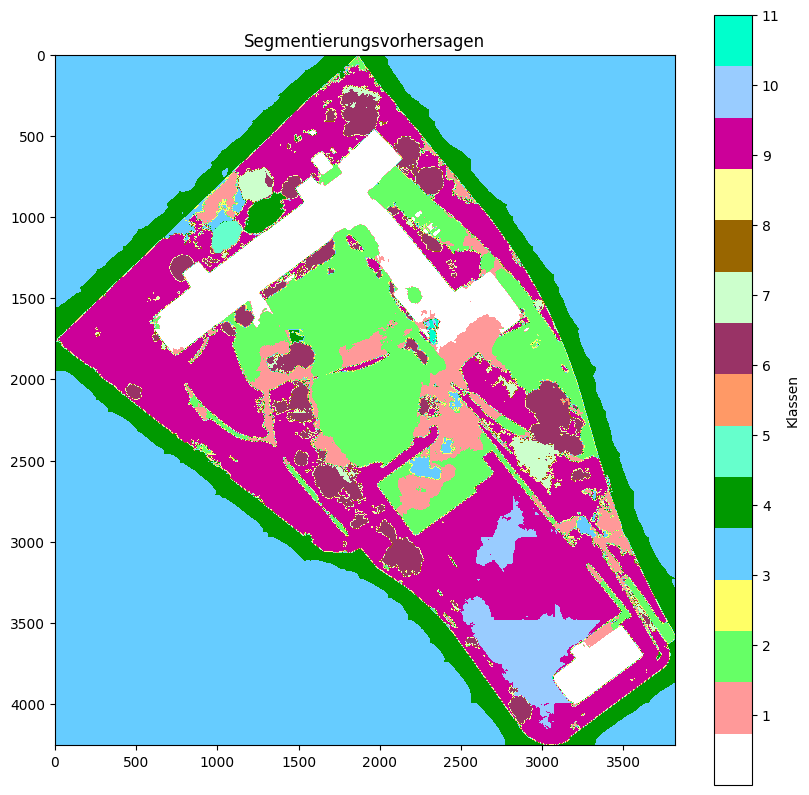

Aktive Klassen in der Vorhersage:
Klasse 1: Gebäude
Klasse 2: Versiegelte Oberfläche
Klasse 3: Unversiegelte Oberfläche
Klasse 4: Unbedeckter Boden
Klasse 5: Wasser
Klasse 6: Nadelbäume
Klasse 7: Laubbäume
Klasse 9: Weinberge
Klasse 10: Krautschicht
Klasse 11: Landwirtschaftliche Fläche


In [ ]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Deine 15 aktiven Klassen in Deutsch
class_labels = {
    1: 'Gebäude',
    2: 'Versiegelte Oberfläche',
    3: 'Unversiegelte Oberfläche',
    4: 'Unbedeckter Boden',
    5: 'Wasser',
    6: 'Nadelbäume',
    7: 'Laubbäume',
    8: 'Gestrüpp',
    9: 'Weinberge',
    10: 'Krautschicht',
    11: 'Landwirtschaftliche Fläche',
    12: 'Pflügbares Land',
    13: 'Schwimmbad',
    14: 'Schnee',
    18: 'Gewächshaus'  # Beachte: Klasse 18 ist noch aktiv
}

# Vorhersage aus der TIFF-Datei laden
tif_file_path = '/content/drive/MyDrive/LabelingModel/output/result_Parzelle_AF2399_2207.tif'  # Ersetze dies durch den Pfad zu deiner TIFF-Datei

with rasterio.open(tif_file_path) as src:
    prediction = src.read(1)  # Lese das erste Band (die Vorhersage)

# Mapping der Vorhersagen nur auf die 15 aktiven Klassen (ignoriere 15, 16, 17, 19)
active_prediction = np.copy(prediction)
active_prediction[np.isin(active_prediction, [15, 16, 17, 19])] = 0  # Deaktivierte Klassen setzen wir auf 0

# Farben für die 15 Klassen (du kannst sie anpassen)
cmap = ListedColormap(['#ffffff', '#ff9999', '#66ff66', '#ffff66', '#66ccff', '#009900', '#66ffcc',
                       '#ff9966', '#993366', '#ccffcc', '#996600', '#ffff99', '#cc0099', '#99ccff', '#00ffcc'])

# Plot der Vorhersage
plt.figure(figsize=(10, 10))
plt.imshow(active_prediction, cmap=cmap)
plt.colorbar(ticks=np.arange(1, 19), label='Klassen')
plt.title("Segmentierungsvorhersagen")
plt.show()

# Ausgabe der Vorhersageklassen mit Namen
unique_classes = np.unique(active_prediction)
print("Aktive Klassen in der Vorhersage:")
for uc in unique_classes:
    if uc in class_labels:
        print(f"Klasse {uc}: {class_labels[uc]}")


also das ergebnis hier ist jetzt die Segmentierung angepasst auf 15 Flächentypen. das wird jetzt verwendet für das weitere vorgehen

## Test mit allen Bildern

In [ ]:
yaml_content = """
output_path: /content/drive/MyDrive/LabelingModel/output
output_name: result_raster

# Verzeichnis mit mehreren Bildern
input_img_dir: /content/drive/MyDrive/Rasterdateien_GemeindeZürich/  # Verzeichnis mit allen TIFF-Dateien
channels: [1, 2, 3, 4]  # RGB + Nahes Infrarot (NIR)

img_pixels_detection: 512
margin: 128
output_type: "argmax"
n_classes: 19

model_weights: /content/drive/MyDrive/LabelingModel/FLAIR-INC_rgbi_15cl_resnet34-unet_weights.pth
model_framework:
    model_provider: SegmentationModelsPytorch
    HuggingFace:
        org_model:
    SegmentationModelsPytorch:
        encoder_decoder: resnet34_unet

batch_size: 4
use_gpu: true
model_name: 'unet'
encoder_name: 'resnet34'
num_worker: 2

write_dataframe: false

norma_task:
  - norm_type: custom
    norm_means: [105.08, 110.87, 101.82, 106.38]
    norm_stds: [52.17, 45.38, 44.0, 39.69]
"""

# Speichere das YAML-File
with open("/content/drive/MyDrive/LabelingModel/flair-1-config-detect_all.yaml", "w") as file:
    file.write(yaml_content)

In [ ]:
import os
import yaml

# Pfade zu den Eingabe- und Ausgabeverzeichnissen
input_folder = "/content/drive/MyDrive/Rasterdateien_GemeindeZürich/"
output_folder = "/content/drive/MyDrive/LabelingModel/output/"

yaml_template = "/content/drive/MyDrive/LabelingModel/flair-1-config-detect_all.yaml"

# Alle Bilddateien im Ordner durchgehen
for filename in os.listdir(input_folder):
    if filename.endswith(".tif"):  # Nur TIFF-Dateien verarbeiten
        input_img_path = os.path.join(input_folder, filename)

        # Output-Dateiname: result_ + der Name der Eingabedatei
        output_img_path = os.path.join(output_folder, f"result_{filename}")

        # Lade die YAML-Konfiguration
        with open(yaml_template, 'r') as f:
            config = yaml.safe_load(f)

        # Aktualisiere die Eingabe- und Ausgabepfade in der YAML-Konfiguration
        config['input_img_path'] = input_img_path
        config['output_name'] = f"result_{filename}"  # Generiere den richtigen Dateinamen

        # Speichere die aktualisierte YAML-Datei
        updated_yaml = f"/content/drive/MyDrive/LabelingModel/flair-1-config-{filename}.yaml"
        with open(updated_yaml, 'w') as f:
            yaml.dump(config, f)

        # Führe flair-detect mit der aktualisierten YAML-Datei aus
        command = f"flair-detect --conf={updated_yaml}"
        print(f"Verarbeite Bild: {filename}")
        os.system(command)



Verarbeite Bild: Parzelle_SE6637_2107.tif
Verarbeite Bild: Parzelle_HG7626_2306.tif
Verarbeite Bild: Parzelle_OB2939_2408.tif
Verarbeite Bild: Parzelle_RI5416_2608.tif
Verarbeite Bild: Parzelle_RI5481_2609.tif
Verarbeite Bild: Parzelle_OB3455_2308.tif
Verarbeite Bild: Parzelle_AL7430_2405.tif
Verarbeite Bild: Parzelle_WO1900_2707.tif
Verarbeite Bild: Parzelle_AF2399_2207.tif
Verarbeite Bild: Parzelle_WI3878_2609.tif
Verarbeite Bild: Parzelle_IQ6786_2407.tif
Verarbeite Bild: Parzelle_HG7909_2306.tif
Verarbeite Bild: Parzelle_IQ7084_2407.tif
Verarbeite Bild: Parzelle_WO4730_2707.tif


Verarbeite Datei: result_Parzelle_SE6637_2107.tif


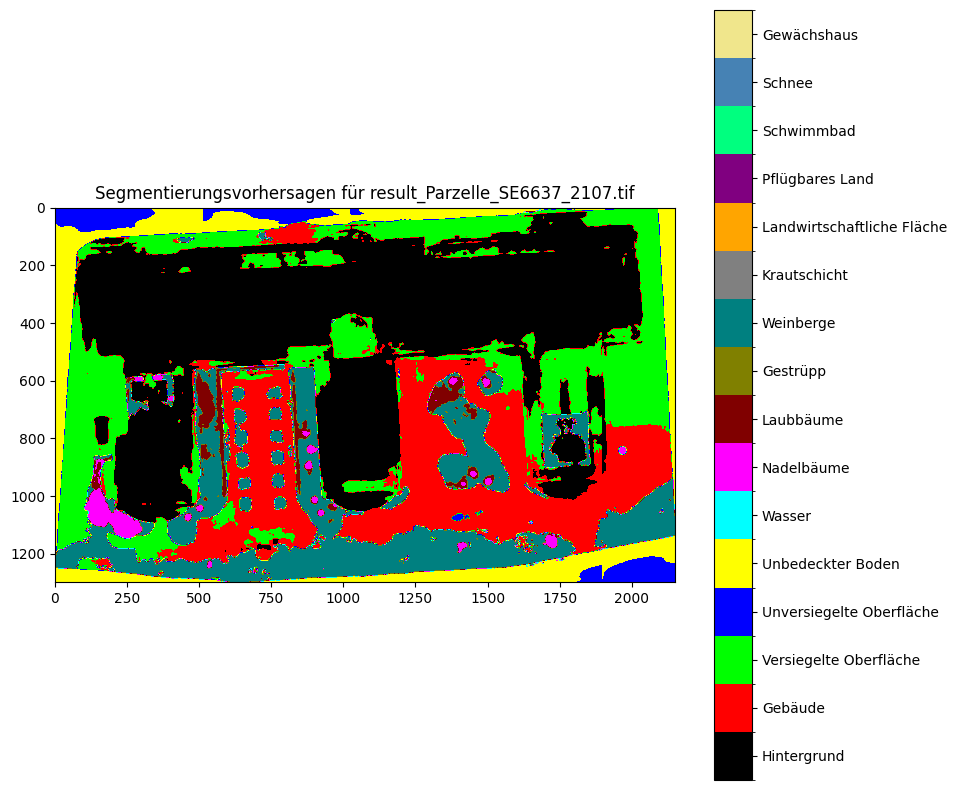

Aktive Klassen in der Vorhersage:
Klasse 0: Hintergrund
Klasse 1: Gebäude
Klasse 2: Versiegelte Oberfläche
Klasse 3: Unversiegelte Oberfläche
Klasse 4: Unbedeckter Boden
Klasse 6: Nadelbäume
Klasse 7: Laubbäume
Klasse 9: Weinberge
Klasse 13: Schwimmbad
Verarbeite Datei: result_Parzelle_HG7626_2306.tif


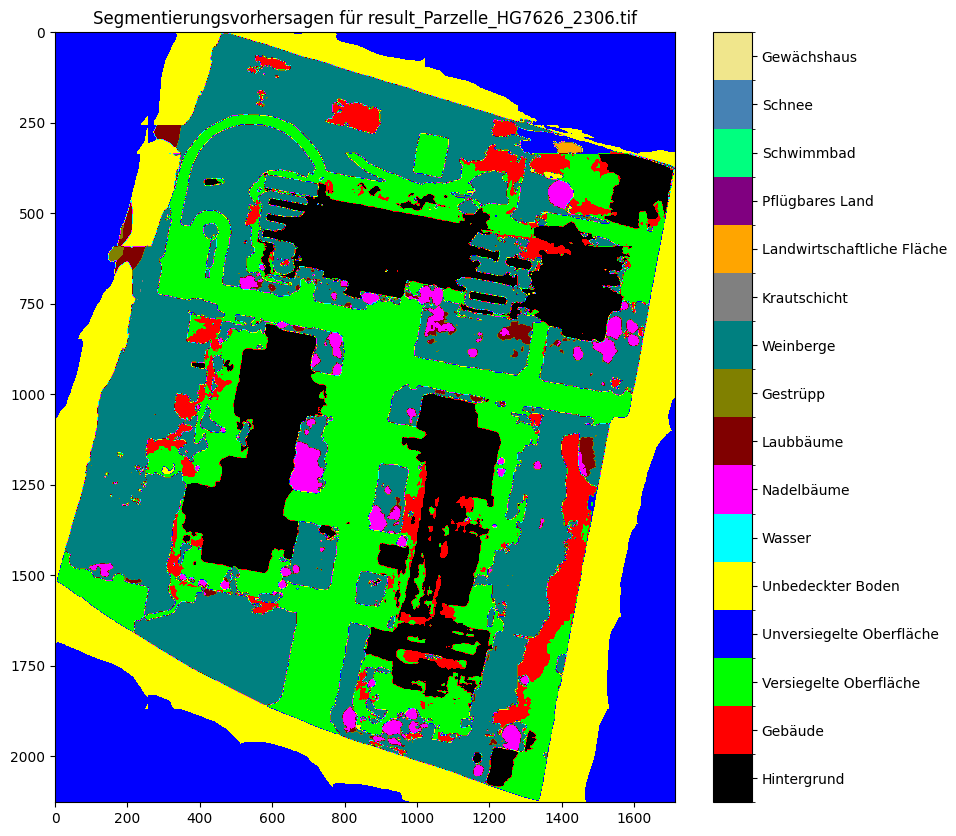

Aktive Klassen in der Vorhersage:
Klasse 0: Hintergrund
Klasse 1: Gebäude
Klasse 2: Versiegelte Oberfläche
Klasse 3: Unversiegelte Oberfläche
Klasse 4: Unbedeckter Boden
Klasse 5: Wasser
Klasse 6: Nadelbäume
Klasse 7: Laubbäume
Klasse 8: Gestrüpp
Klasse 9: Weinberge
Klasse 10: Krautschicht
Klasse 11: Landwirtschaftliche Fläche
Verarbeite Datei: result_Parzelle_OB2939_2408.tif


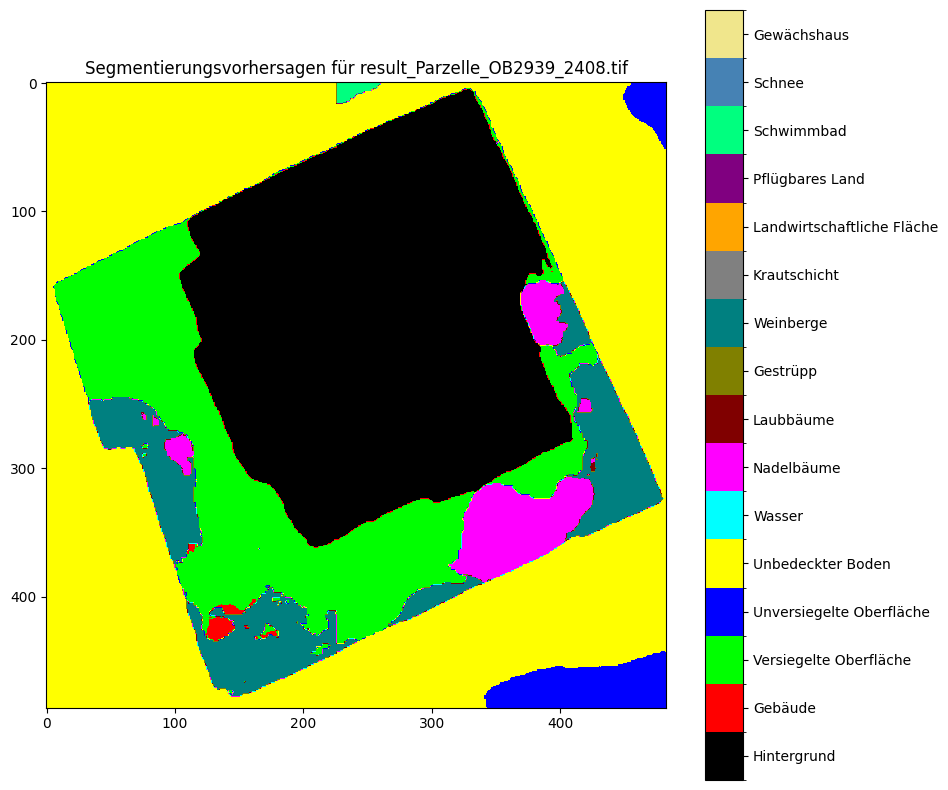

Aktive Klassen in der Vorhersage:
Klasse 0: Hintergrund
Klasse 1: Gebäude
Klasse 2: Versiegelte Oberfläche
Klasse 3: Unversiegelte Oberfläche
Klasse 4: Unbedeckter Boden
Klasse 6: Nadelbäume
Klasse 7: Laubbäume
Klasse 9: Weinberge
Klasse 13: Schwimmbad
Verarbeite Datei: result_Parzelle_RI5416_2608.tif


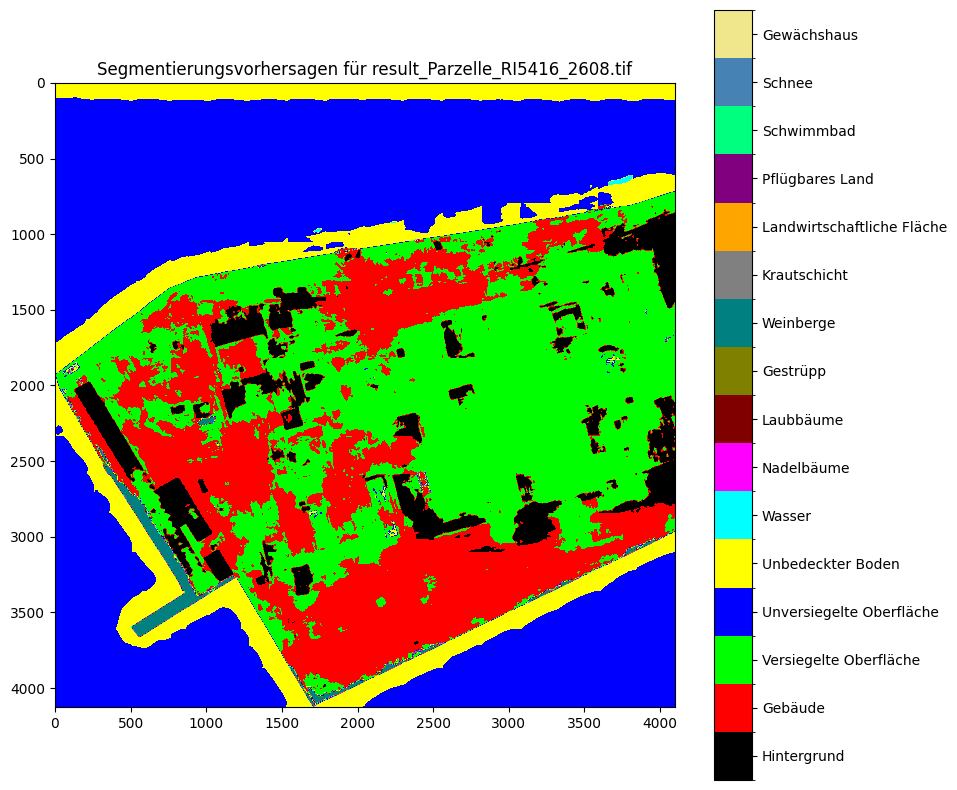

Aktive Klassen in der Vorhersage:
Klasse 0: Hintergrund
Klasse 1: Gebäude
Klasse 2: Versiegelte Oberfläche
Klasse 3: Unversiegelte Oberfläche
Klasse 4: Unbedeckter Boden
Klasse 5: Wasser
Klasse 9: Weinberge
Klasse 12: Pflügbares Land
Klasse 13: Schwimmbad
Verarbeite Datei: result_Parzelle_RI5481_2609.tif


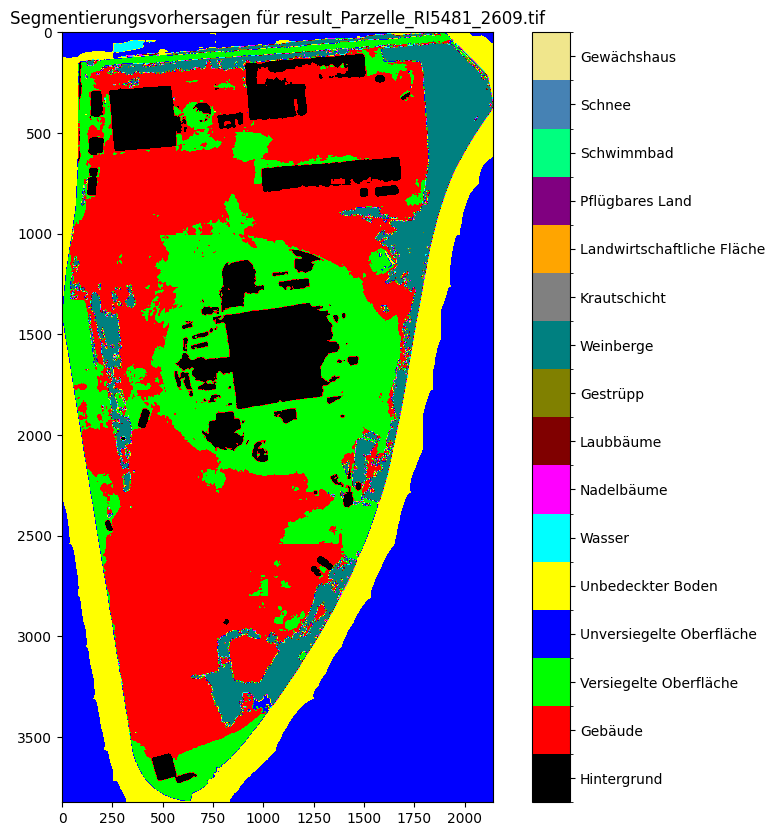

Aktive Klassen in der Vorhersage:
Klasse 0: Hintergrund
Klasse 1: Gebäude
Klasse 2: Versiegelte Oberfläche
Klasse 3: Unversiegelte Oberfläche
Klasse 4: Unbedeckter Boden
Klasse 5: Wasser
Klasse 9: Weinberge
Klasse 13: Schwimmbad
Verarbeite Datei: result_Parzelle_OB3455_2308.tif


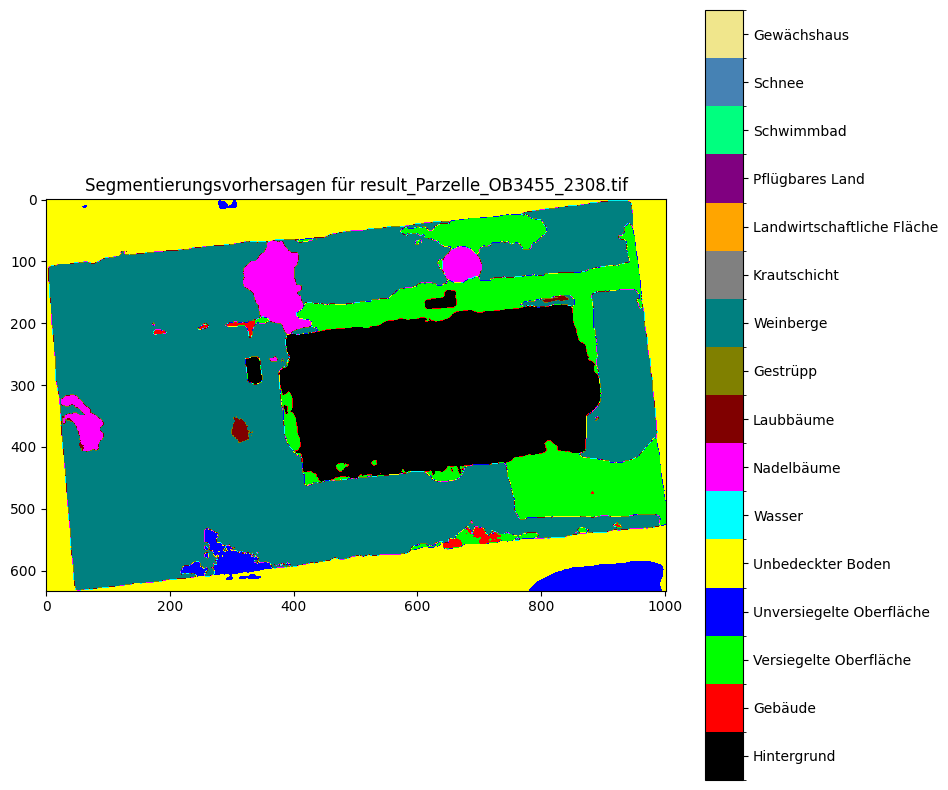

Aktive Klassen in der Vorhersage:
Klasse 0: Hintergrund
Klasse 1: Gebäude
Klasse 2: Versiegelte Oberfläche
Klasse 3: Unversiegelte Oberfläche
Klasse 4: Unbedeckter Boden
Klasse 6: Nadelbäume
Klasse 7: Laubbäume
Klasse 9: Weinberge
Verarbeite Datei: result_Parzelle_AL7430_2405.tif


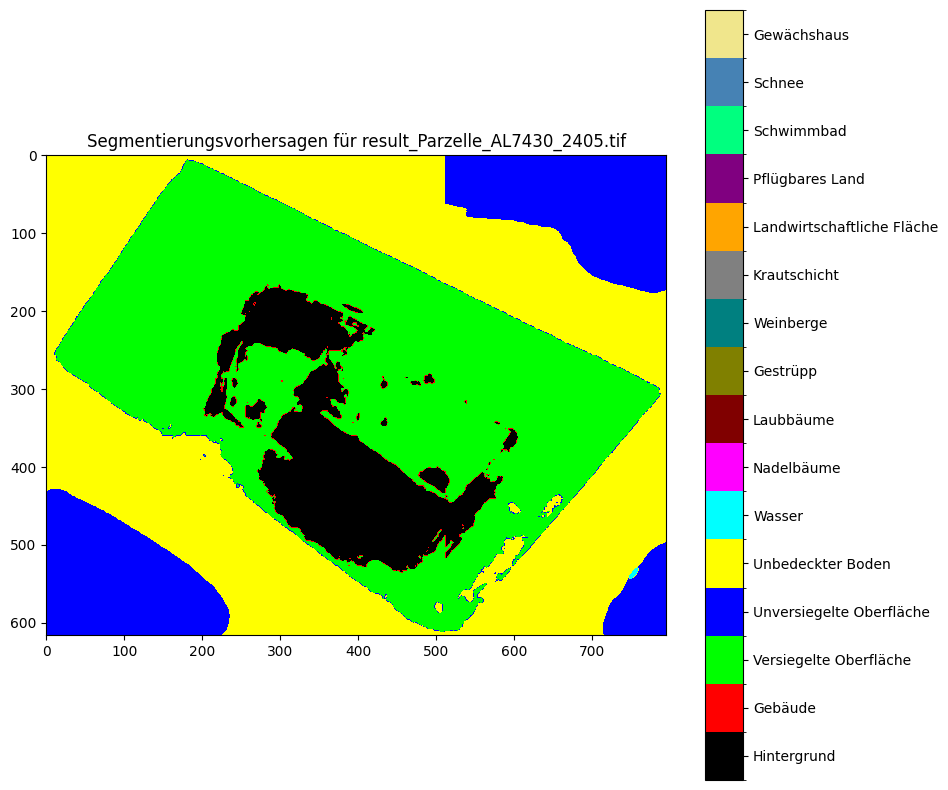

Aktive Klassen in der Vorhersage:
Klasse 0: Hintergrund
Klasse 2: Versiegelte Oberfläche
Klasse 3: Unversiegelte Oberfläche
Klasse 4: Unbedeckter Boden
Klasse 5: Wasser
Verarbeite Datei: result_Parzelle_WO1900_2707.tif


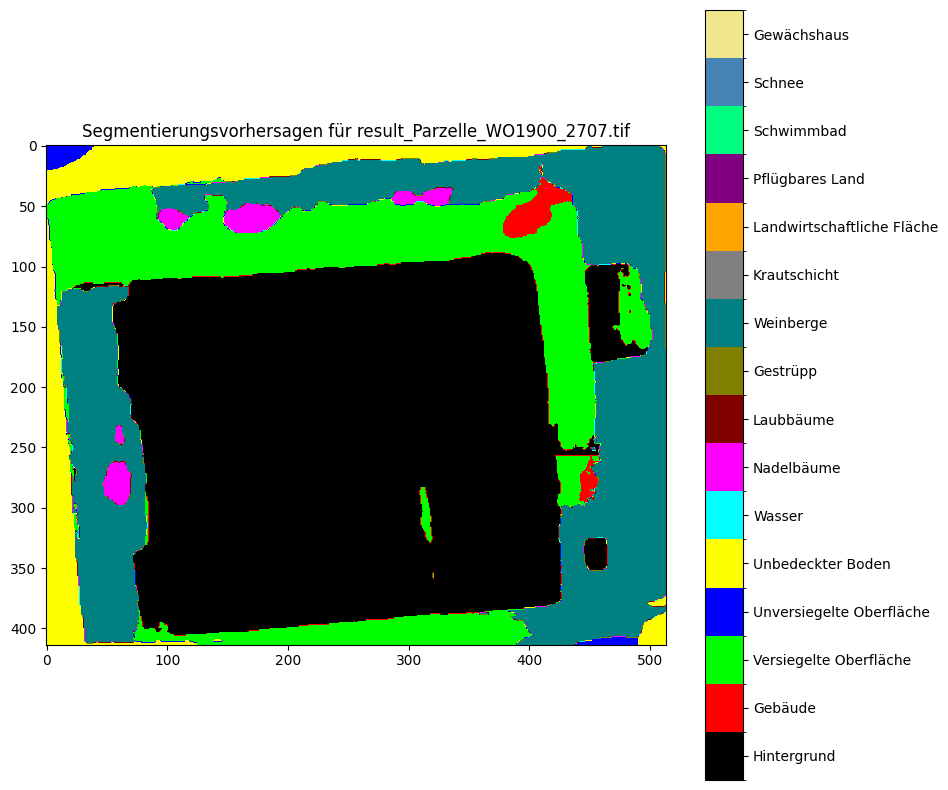

Aktive Klassen in der Vorhersage:
Klasse 0: Hintergrund
Klasse 1: Gebäude
Klasse 2: Versiegelte Oberfläche
Klasse 3: Unversiegelte Oberfläche
Klasse 4: Unbedeckter Boden
Klasse 6: Nadelbäume
Klasse 9: Weinberge
Verarbeite Datei: result_Parzelle_AF2399_2207.tif


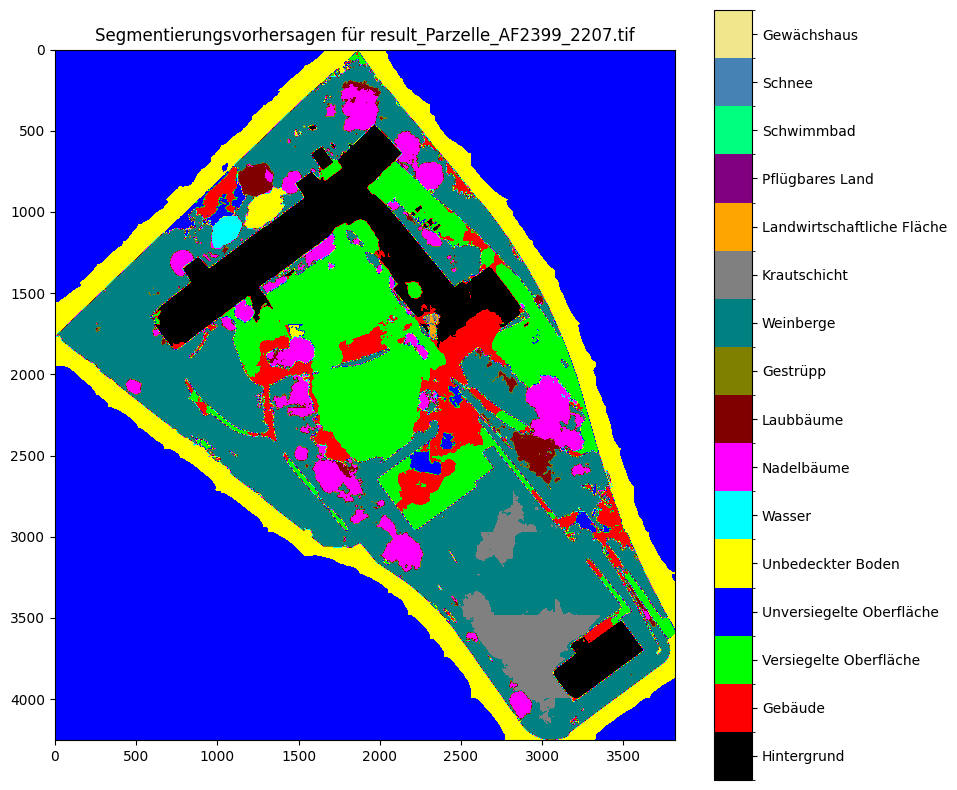

Aktive Klassen in der Vorhersage:
Klasse 0: Hintergrund
Klasse 1: Gebäude
Klasse 2: Versiegelte Oberfläche
Klasse 3: Unversiegelte Oberfläche
Klasse 4: Unbedeckter Boden
Klasse 5: Wasser
Klasse 6: Nadelbäume
Klasse 7: Laubbäume
Klasse 9: Weinberge
Klasse 10: Krautschicht
Klasse 11: Landwirtschaftliche Fläche
Verarbeite Datei: result_Parzelle_WI3878_2609.tif


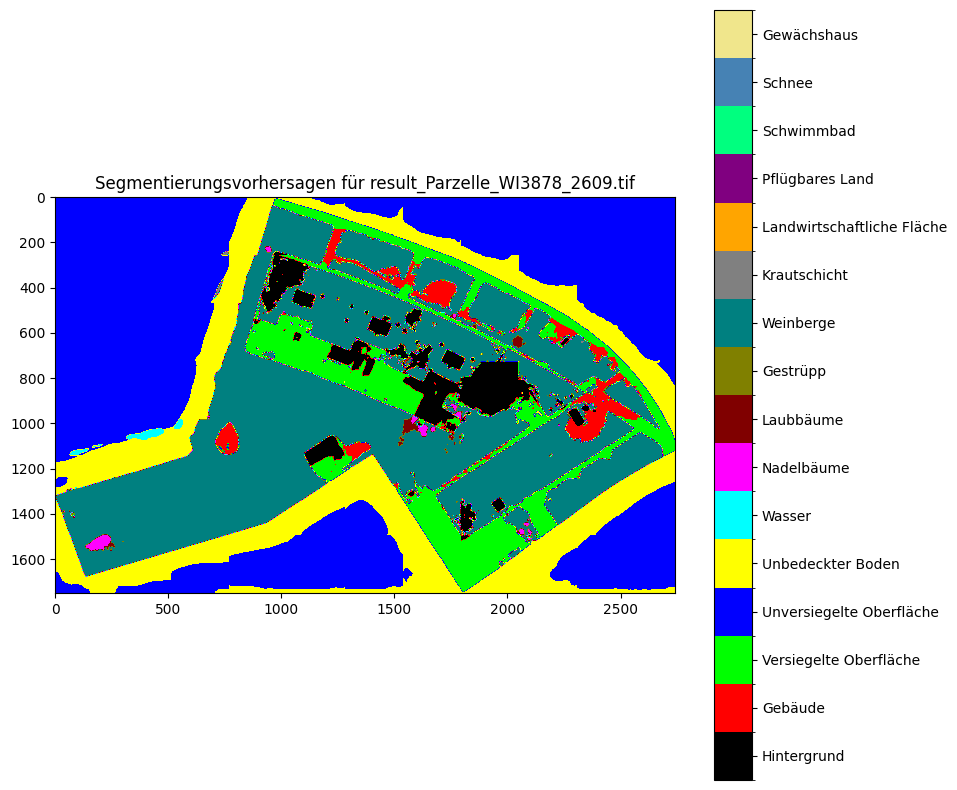

Aktive Klassen in der Vorhersage:
Klasse 0: Hintergrund
Klasse 1: Gebäude
Klasse 2: Versiegelte Oberfläche
Klasse 3: Unversiegelte Oberfläche
Klasse 4: Unbedeckter Boden
Klasse 5: Wasser
Klasse 6: Nadelbäume
Klasse 7: Laubbäume
Klasse 9: Weinberge
Klasse 10: Krautschicht
Verarbeite Datei: result_Parzelle_IQ6786_2407.tif


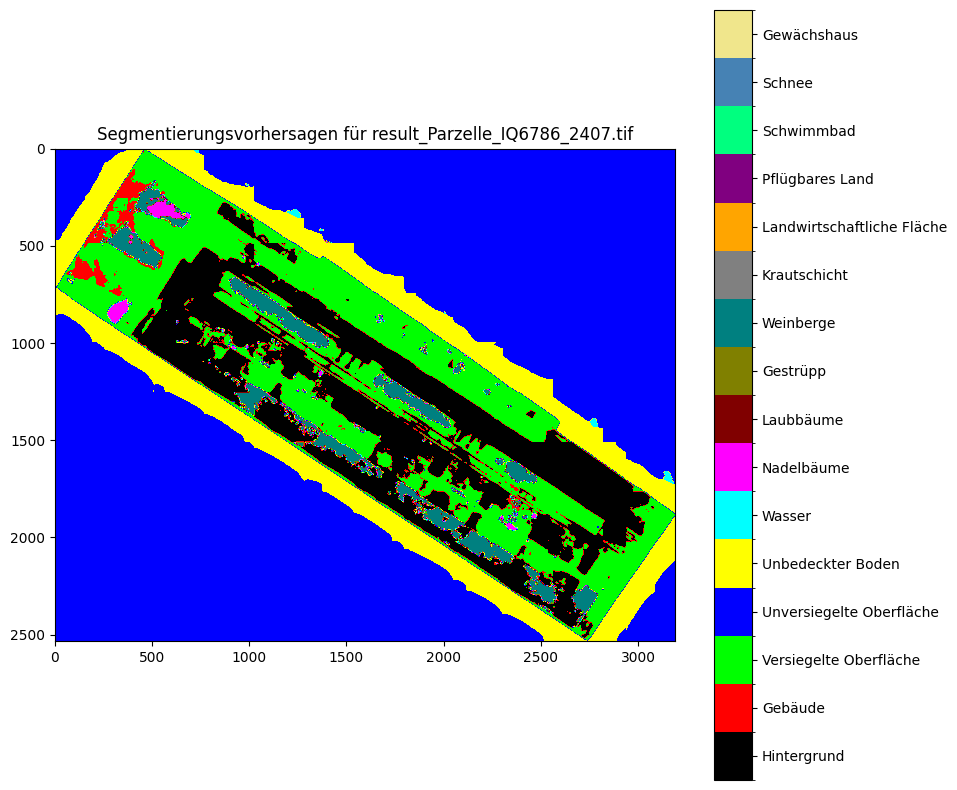

Aktive Klassen in der Vorhersage:
Klasse 0: Hintergrund
Klasse 1: Gebäude
Klasse 2: Versiegelte Oberfläche
Klasse 3: Unversiegelte Oberfläche
Klasse 4: Unbedeckter Boden
Klasse 5: Wasser
Klasse 6: Nadelbäume
Klasse 7: Laubbäume
Klasse 9: Weinberge
Klasse 10: Krautschicht
Klasse 13: Schwimmbad
Verarbeite Datei: result_Parzelle_HG7909_2306.tif


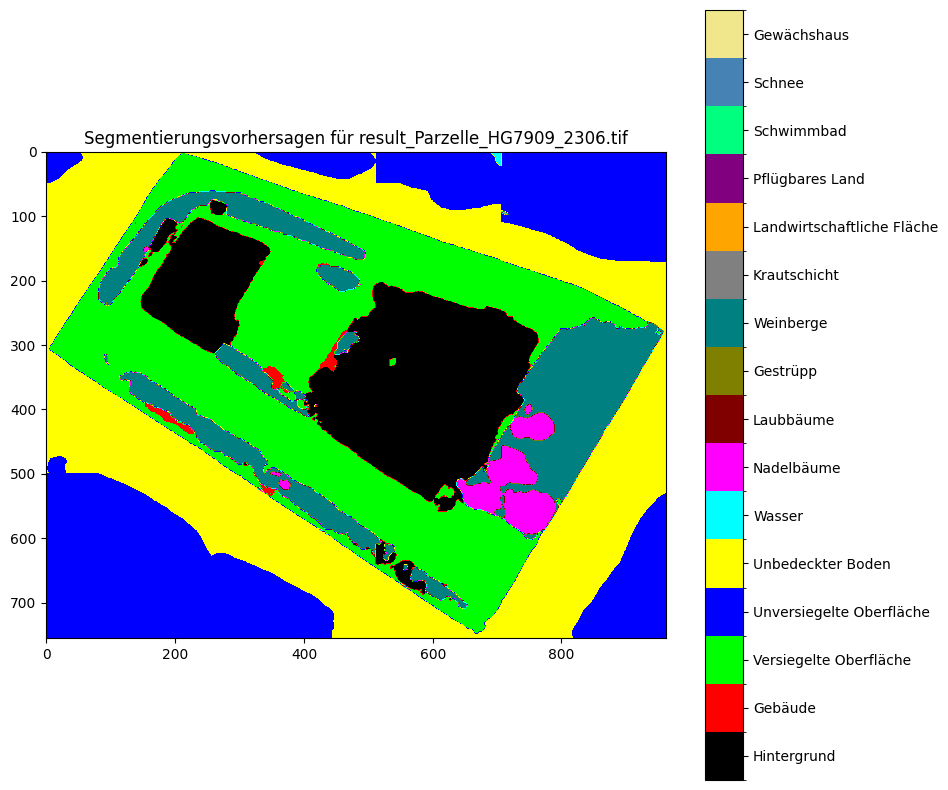

Aktive Klassen in der Vorhersage:
Klasse 0: Hintergrund
Klasse 1: Gebäude
Klasse 2: Versiegelte Oberfläche
Klasse 3: Unversiegelte Oberfläche
Klasse 4: Unbedeckter Boden
Klasse 5: Wasser
Klasse 6: Nadelbäume
Klasse 9: Weinberge
Klasse 13: Schwimmbad
Verarbeite Datei: result_Parzelle_IQ7084_2407.tif


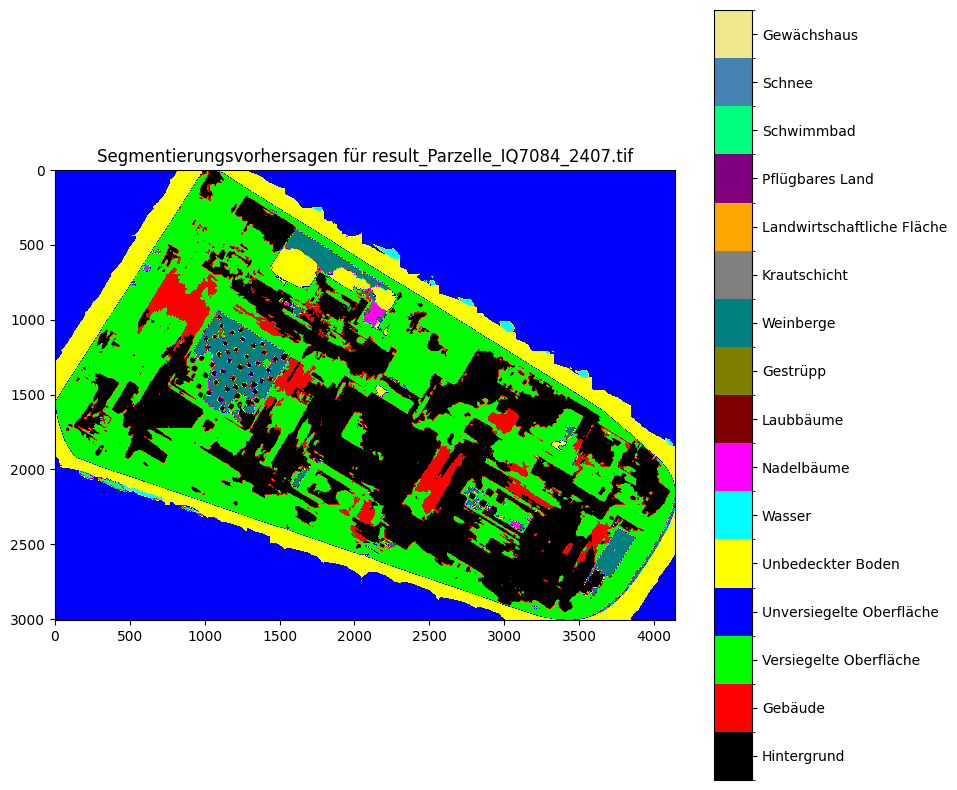

Aktive Klassen in der Vorhersage:
Klasse 0: Hintergrund
Klasse 1: Gebäude
Klasse 2: Versiegelte Oberfläche
Klasse 3: Unversiegelte Oberfläche
Klasse 4: Unbedeckter Boden
Klasse 5: Wasser
Klasse 6: Nadelbäume
Klasse 7: Laubbäume
Klasse 9: Weinberge
Klasse 12: Pflügbares Land
Klasse 13: Schwimmbad
Verarbeite Datei: result_Parzelle_WO4730_2707.tif


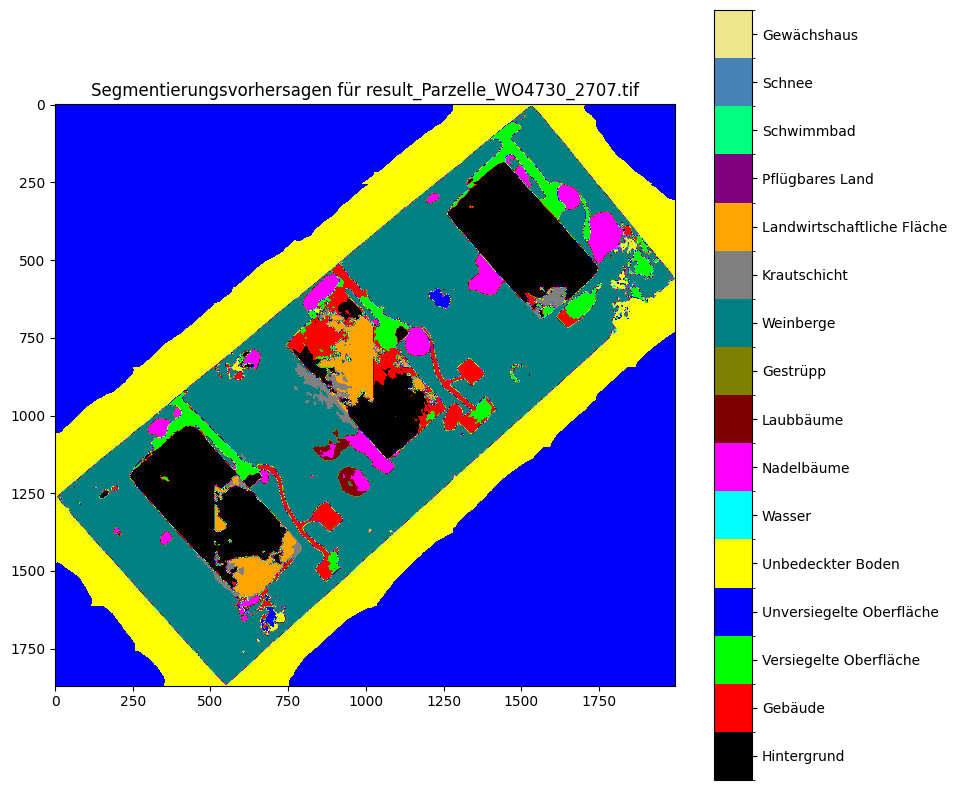

Aktive Klassen in der Vorhersage:
Klasse 0: Hintergrund
Klasse 1: Gebäude
Klasse 2: Versiegelte Oberfläche
Klasse 3: Unversiegelte Oberfläche
Klasse 4: Unbedeckter Boden
Klasse 5: Wasser
Klasse 6: Nadelbäume
Klasse 7: Laubbäume
Klasse 9: Weinberge
Klasse 10: Krautschicht
Klasse 11: Landwirtschaftliche Fläche


In [ ]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
import os

# Pfad zu deinem Ordner mit den gespeicherten TIFF-Dateien
output_folder = "/content/drive/MyDrive/LabelingModel/output/"

# Klassen mit eindeutigen Farben und Beschriftungen
class_labels_with_colors = {
    1: ('Gebäude', '#ff0000'),                  # Rot
    2: ('Versiegelte Oberfläche', '#00ff00'),  # Grün
    3: ('Unversiegelte Oberfläche', '#0000ff'),# Blau
    4: ('Unbedeckter Boden', '#ffff00'),       # Gelb
    5: ('Wasser', '#00ffff'),                  # Cyan
    6: ('Nadelbäume', '#ff00ff'),              # Magenta
    7: ('Laubbäume', '#800000'),               # Dunkelrot
    8: ('Gestrüpp', '#808000'),                # Oliv
    9: ('Weinberge', '#008080'),               # Dunkelcyan
    10: ('Krautschicht', '#808080'),           # Grau
    11: ('Landwirtschaftliche Fläche', '#ffa500'), # Orange
    12: ('Pflügbares Land', '#800080'),        # Lila
    13: ('Schwimmbad', '#00ff7f'),             # Frühlinggrün
    14: ('Schnee', '#4682b4'),                 # Stahlblau
    18: ('Gewächshaus', '#f0e68c'),            # Hellgelb
    0: ('Hintergrund', '#000000')              # Schwarz
}

# Liste der Farben und Labels für die Farbkarten
colors = [class_labels_with_colors[key][1] for key in sorted(class_labels_with_colors.keys())]
labels = [class_labels_with_colors[key][0] for key in sorted(class_labels_with_colors.keys())]

# Erstelle die Colormap und Norm
cmap = ListedColormap(colors)
norm = BoundaryNorm(boundaries=np.arange(len(colors) + 1) - 0.5, ncolors=len(colors))

# Alle TIFF-Dateien im Ordner durchgehen und visualisieren
for filename in os.listdir(output_folder):
    if filename.endswith(".tif"):  # Nur TIFF-Dateien verarbeiten
        tif_file_path = os.path.join(output_folder, filename)
        print(f"Verarbeite Datei: {filename}")

        # Vorhersage aus der TIFF-Datei laden
        with rasterio.open(tif_file_path) as src:
            prediction = src.read(1)  # Lese das erste Band (die Vorhersage)

        # Mapping der Vorhersagen nur auf die aktiven Klassen (ignoriere inaktive Klassen)
        active_prediction = np.copy(prediction)
        active_prediction[~np.isin(active_prediction, list(class_labels_with_colors.keys()))] = 0

        # Plot der Vorhersage
        plt.figure(figsize=(10, 10))
        img = plt.imshow(active_prediction, cmap=cmap, norm=norm)
        cbar = plt.colorbar(img, ticks=np.arange(len(colors)), orientation="vertical")
        cbar.ax.set_yticklabels(labels)  # Beschriftung der Farblegende
        plt.title(f"Segmentierungsvorhersagen für {filename}")
        plt.show()

        # Ausgabe der Vorhersageklassen mit Namen
        unique_classes = np.unique(active_prediction)
        print("Aktive Klassen in der Vorhersage:")
        for uc in unique_classes:
            if uc in class_labels_with_colors:
                print(f"Klasse {uc}: {class_labels_with_colors[uc][0]}")


Anhand der Bildanalyse können wir zwar erkennen, dass die Flächentypen Umrisse und Formen der gegebenen Rasterdatei erkennen können. Allerdings werden die Umrisse falsch zugeordnet. Beispeilsweise wird das Gebäude fast durchgängig als Hintergrund klassifiziert.

## Mapping der BFF Werte

Anhand der Informationen, der FLAIR Dokumentation (https://arxiv.org/pdf/2211.12979), welche Klasse als was interperteriert wird, werden die BFF Flächentypen zugeordnet. Hierbei werden die Kennzeichnungen von FLAIR-INC nach Rücksprache mit BioVales (Katrin) den BFF Flächentypen zugeordnet.

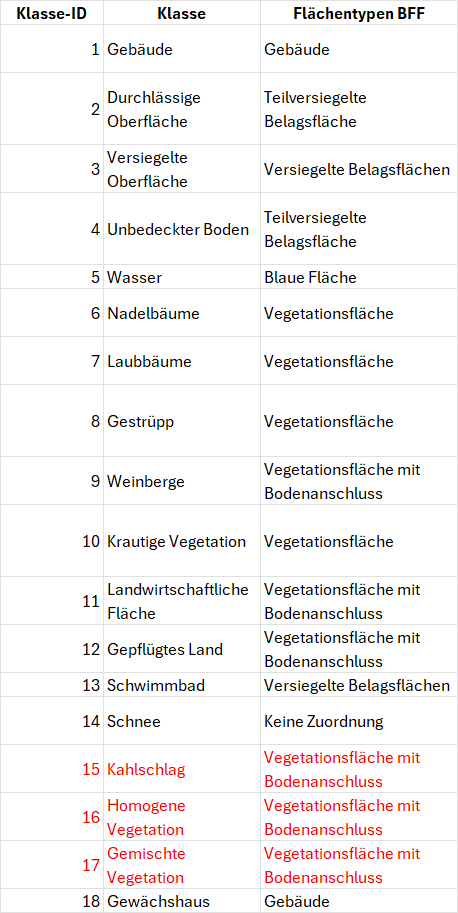

In [ ]:
import os
import numpy as np
import rasterio
from PIL import Image
from matplotlib.colors import ListedColormap

# Pfad zu deinem Ordner mit den gespeicherten TIFF-Dateien
input_folder = "/content/drive/MyDrive/LabelingModel/output/"
output_png_folder = "/content/drive/MyDrive/LabelingModel/png_output/"

# Mapping der FLAIR IDs zu BFF IDs
FLAIR_TO_BFF_MAPPING = {
    1: 1,  2: 2,  3: 3,  13: 3, 18: 1, 4: 2, 5: 4, 14: 5, 6: 5,
    7: 5,  8: 5, 15: 6, 16: 6, 17: 6, 9: 6, 11: 6, 12: 6, 10: 5
}

# Farben für die BFF-Klassen
BFF_COLORS = {
    1: (139, 0, 0),     # Gebäude
    2: (255, 140, 0),   # Teilversiegelte Belagsfläche
    3: (255, 215, 0),   # Versiegelte Belagsfläche
    4: (42, 125, 209),  # Blaue Fläche
    5: (0, 100, 0),     # Vegetationsfläche
    6: (50, 205, 50),   # Vegetationsfläche mit Bodenanschluss
    0: (0, 0, 0)        # Hintergrund
}

# Sicherstellen, dass das Ausgabeordner existiert
os.makedirs(output_png_folder, exist_ok=True)

# Durch alle TIFF-Dateien iterieren
for filename in os.listdir(input_folder):
    if filename.endswith(".tif"):  # Nur TIFF-Dateien verarbeiten
        input_path = os.path.join(input_folder, filename)
        output_png_path = os.path.join(output_png_folder, filename.replace(".tif", ".png"))

        # TIFF-Datei laden
        with rasterio.open(input_path) as src:
            data = src.read(1)  # Nur das erste Band (Klassennummern)

        # Mapping der FLAIR-Klassen auf BFF-Klassen
        mapped_data = np.zeros_like(data, dtype=np.uint8)
        for original_class, bff_class in FLAIR_TO_BFF_MAPPING.items():
            mapped_data[data == original_class] = bff_class

        # Farbmapping anwenden
        rgb_image = np.zeros((mapped_data.shape[0], mapped_data.shape[1], 3), dtype=np.uint8)
        for bff_class, color in BFF_COLORS.items():
            rgb_image[mapped_data == bff_class] = color

        # RGB-Bild speichern
        output_image = Image.fromarray(rgb_image)
        output_image.save(output_png_path)

        print(f"Konvertierte Datei gespeichert: {output_png_path}")


Konvertierte Datei gespeichert: /content/drive/MyDrive/LabelingModel/png_output/result_Parzelle_SE6637_2107.png
Konvertierte Datei gespeichert: /content/drive/MyDrive/LabelingModel/png_output/result_Parzelle_HG7626_2306.png
Konvertierte Datei gespeichert: /content/drive/MyDrive/LabelingModel/png_output/result_Parzelle_OB2939_2408.png
Konvertierte Datei gespeichert: /content/drive/MyDrive/LabelingModel/png_output/result_Parzelle_RI5416_2608.png
Konvertierte Datei gespeichert: /content/drive/MyDrive/LabelingModel/png_output/result_Parzelle_RI5481_2609.png
Konvertierte Datei gespeichert: /content/drive/MyDrive/LabelingModel/png_output/result_Parzelle_OB3455_2308.png
Konvertierte Datei gespeichert: /content/drive/MyDrive/LabelingModel/png_output/result_Parzelle_AL7430_2405.png
Konvertierte Datei gespeichert: /content/drive/MyDrive/LabelingModel/png_output/result_Parzelle_WO1900_2707.png
Konvertierte Datei gespeichert: /content/drive/MyDrive/LabelingModel/png_output/result_Parzelle_AF2399_2

## Analyse

In [ ]:
import os
import numpy as np
from PIL import Image
from sklearn.metrics import confusion_matrix, accuracy_score, jaccard_score

# Pfade zu den Verzeichnissen
flair_masks_folder = "/content/drive/MyDrive/LabelingModel/png_output/"
ground_truth_folder = "/content/drive/MyDrive/GroundTruthData/SegmentationMasks/"

# Funktion zum Berechnen der IoU für jede Klasse
def calculate_iou(prediction, ground_truth, num_classes):
    ious = []
    for cls in range(num_classes):
        pred_cls = prediction == cls
        gt_cls = ground_truth == cls
        intersection = np.logical_and(pred_cls, gt_cls).sum()
        union = np.logical_or(pred_cls, gt_cls).sum()
        if union == 0:
            ious.append(np.nan)  # Wenn kein Union vorhanden ist, wird NaN verwendet
        else:
            ious.append(intersection / union)
    return ious

# Ergebnisse speichern
results = []

# Durch die vorhergesagten Masken iterieren
for filename in os.listdir(flair_masks_folder):
    if filename.endswith(".png"):
        # Passender Ground-Truth-Dateiname
        ground_truth_filename = filename.replace("result_", "")

        # Vollständige Pfade
        flair_mask_path = os.path.join(flair_masks_folder, filename)
        ground_truth_path = os.path.join(ground_truth_folder, ground_truth_filename)

        # Überprüfen, ob die Ground-Truth-Datei existiert
        if not os.path.exists(ground_truth_path):
            print(f"Ground-Truth-Datei nicht gefunden: {ground_truth_path}")
            continue

        # Masken laden
        flair_mask = np.array(Image.open(flair_mask_path))
        ground_truth_mask = np.array(Image.open(ground_truth_path))

        # Sicherstellen, dass die Masken dieselbe Form haben
        if flair_mask.shape != ground_truth_mask.shape:
            print(f"Formunterschied bei {filename}: {flair_mask.shape} vs {ground_truth_mask.shape}")
            continue

        # Metriken berechnen
        accuracy = accuracy_score(ground_truth_mask.flatten(), flair_mask.flatten())
        mean_iou = np.nanmean(calculate_iou(flair_mask, ground_truth_mask, num_classes=len(BFF_COLORS)))

        # Ergebnisse speichern
        results.append({
            "Datei": filename,
            "Genauigkeit": accuracy,
            "Mean IoU": mean_iou
        })

        print(f"Datei: {filename} - Genauigkeit: {accuracy:.2f}, Mean IoU: {mean_iou:.2f}")

# Ergebnisse ausgeben
print("\nZusammenfassung der Ergebnisse:")
for result in results:
    print(result)


Datei: result_Parzelle_SE6637_2107.png - Genauigkeit: 0.38, Mean IoU: 0.47
Datei: result_Parzelle_HG7626_2306.png - Genauigkeit: 0.45, Mean IoU: 0.41
Ground-Truth-Datei nicht gefunden: /content/drive/MyDrive/GroundTruthData/SegmentationMasks/Parzelle_OB2939_2408.png
Ground-Truth-Datei nicht gefunden: /content/drive/MyDrive/GroundTruthData/SegmentationMasks/Parzelle_RI5416_2608.png
Ground-Truth-Datei nicht gefunden: /content/drive/MyDrive/GroundTruthData/SegmentationMasks/Parzelle_RI5481_2609.png
Datei: result_Parzelle_OB3455_2308.png - Genauigkeit: 0.56, Mean IoU: 0.40
Ground-Truth-Datei nicht gefunden: /content/drive/MyDrive/GroundTruthData/SegmentationMasks/Parzelle_AL7430_2405.png
Datei: result_Parzelle_WO1900_2707.png - Genauigkeit: 0.56, Mean IoU: 0.54
Datei: result_Parzelle_AF2399_2207.png - Genauigkeit: 0.48, Mean IoU: 0.37
Datei: result_Parzelle_WI3878_2609.png - Genauigkeit: 0.43, Mean IoU: 0.33
Ground-Truth-Datei nicht gefunden: /content/drive/MyDrive/GroundTruthData/Segmenta

Die Labels wurden nun theoretisch anhand der Informationen gemapped. Allerdings sieht man anhand der Bildanalyse, dass man statt anhand der Informationen besser anhand der Labels mappen würde. zB dass man Hintergrund dem BFF Faktor Gebäude zuordnet. Das heisst, das Modell weisst zwar die falschen Flächentypen im ersten Schritt zu, durch die Bildanalyse könnte man aber die Labels detaillierter zuordnen.

Nachdem die Klassen nicht passen für mein MOdell muss ich das jetzt noch manuell detaillierter Labeln
